---
title: Transformer for timeseries
author: "Dien-Hoa Truong"
date: 2023-04-26
categories: [timeseries, deeplearning, transformer]

---

Developing an Intuition for Transformers and Applying Them to Time Series Classification

![Transformer Architecture](https://pytorch.org/tutorials/_images/transformer_architecture.jpg)

Struggling to learn a new deep learning architecture, such as Transformer, can be quite challenging. However, it doesn't have to be so daunting. In this blog post, I will demonstrate a practical approach to start using a new architecture, specifically the Transformer. We will construct a basic Transformer architecture and progressively fine-tune it to achieve the performance of the TST architecture (A Transformer-based Framework for Multivariate Time Series Representation Learning).

**Content:**

- Dataset to use: [FaceDetection](https://www.timeseriesclassification.com/description.php?Dataset=FaceDetection)
- Reference Model: [TST Model](https://timeseriesai.github.io/tsai/models.tst.html) implemented in tsai repository
- Baseline Model: LSTM Model 
- Our TST Model

**References:**

- [tsai repository](https://github.com/timeseriesAI/tsai)
- [How to use Transformers with TimeSeries Tutorial](https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb)


In [ ]:
!pip install -Uqq tsai

In [ ]:
import torch
from torch.utils.data import Dataset
from torch import nn
from fastai.data.core import DataLoader, DataLoaders
from fastai.learner import Learner
from fastai.losses import LabelSmoothingCrossEntropyFlat
from fastai.metrics import RocAucBinary, accuracy
from fastai.torch_core import Module
from tsai.models.TST import TST
from tsai.models.RNN import LSTM
from tsai.data.external import get_UCR_data
from tsai.callback.core import ShowGraph as ShowGraphCallback2
from tsai.learner import plot_metrics

## Dataset: [FaceDetection](https://www.timeseriesclassification.com/description.php?Dataset=FaceDetection)

:::{.callout-note}

Why Time Series? Although the Transformer originates from the NLP domain and outperforms all previous architectures, I believe that, for those not yet familiar with NLP, it is more advantageous to start with a domain that requires less preprocessing, such as Time Series. This way, we can focus our attention on understanding the architecture itself.

:::


In this tutorial, we will be using a dataset from the well-known UEA & UCR Time Series repository. Although we won't delve into the details of this dataset in this blog post, it's worth mentioning its purpose. The objective is to classify whether a given MEG signal (Magnetoencephalography) represents a face or not. The input dimension is 144, and the sequence length is 62.

I chose this dataset because it contains a reasonable amount of data (5,890 training instances and 3,524 testing instances) and has been used in a Transformer tutorial in the tsai repository. This ensures that we have a reliable reference model to aim to outperform.

We will utilize utility functions from the tsai and fastai libraries to facilitate our work and streamline the process.

In [ ]:
batch_size, c_in, c_out, seq_len = 64, 144, 2, 62
X, y, splits = get_UCR_data('FaceDetection', return_split=False)

X_train = X[splits[0]]
y_train = y[splits[0]]
X_valid = X[splits[1]]
y_valid = y[splits[1]]

In [ ]:
class TSDataset(Dataset):
    """TimeSeries DataSet for FaceDetection"""
    def __init__(self, X, y):
        super(TSDataset, self).__init__()
        self.X = torch.tensor(X)
        self.Y = torch.concat([torch.tensor([_y == '0'], dtype=int) for _y in y])
    
    def __len__(self): return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

The following code demonstrates how to create data loaders for the training and validation sets:

In [ ]:
dset_train = TSDataset(X_train, y_train)
dset_valid = TSDataset(X_valid, y_valid)

dl_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dl_valid = DataLoader(dset_valid, batch_size=batch_size, shuffle=False)

dls = DataLoaders(dl_train, dl_valid) 
dls = dls.cuda()

In [ ]:
x, y = next(iter(dl_train))

In [ ]:
x.shape, y.shape

(torch.Size([64, 144, 62]), torch.Size([64]))

## Reference Model

The reference model we will be using is the [TST](https://arxiv.org/abs/2010.02803) (Transformer-based Framework for Multivariate Time Series Representation Learning) and implemented by the tsai library.

In [ ]:
def evaluate_model(model):
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), 
                    metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
    learn.fit_one_cycle(30, 1e-4) 

In [ ]:
model = TST(c_in, c_out, seq_len, dropout=0.3, fc_dropout=0.9,n_heads=1)

In [ ]:
model

TST(
  (W_P): Linear(in_features=144, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0): _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
        )
        (dropout_attn): Dropout(p=0.3, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose(1, 2)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose(1, 2)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.3, inplace=False)
          (3): Linear(in_features=25

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.951646,0.708477,0.506569,0.508229,00:03
1,0.970950,0.704351,0.516325,0.513621,00:02
2,0.938998,0.702305,0.532927,0.520715,00:02
3,0.921369,0.691450,0.571081,0.551930,00:02
4,0.900328,0.681608,0.611268,0.576617,00:02
5,0.863914,0.674634,0.637967,0.599035,00:03
6,0.823749,0.668968,0.661042,0.613791,00:03
7,0.779181,0.661584,0.679245,0.628831,00:03
8,0.773248,0.655216,0.689473,0.641600,00:03
9,0.736231,0.656833,0.693580,0.639614,00:03


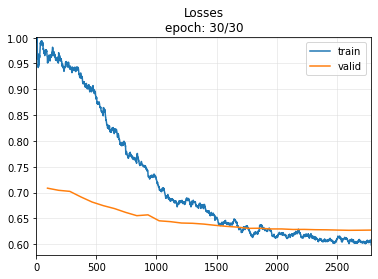

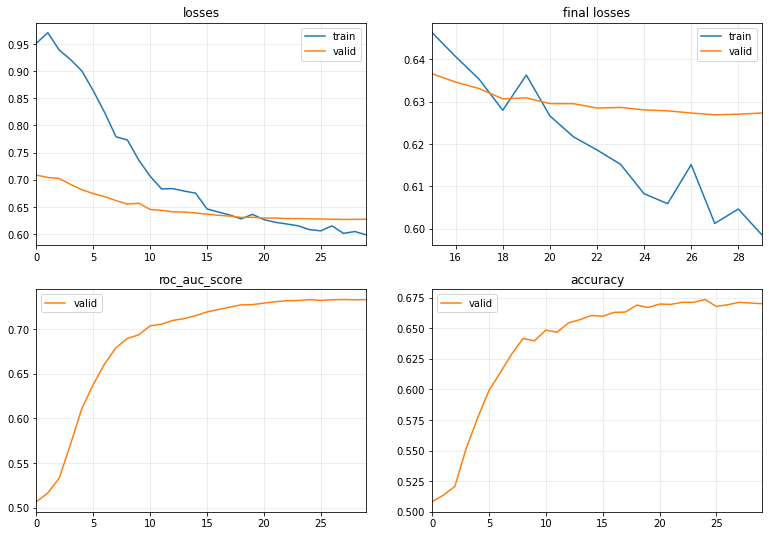

In [ ]:
evaluate_model(model)

## Baseline

We'll begin our journey by exploring an LSTM model, which was commonly used for sequence classification in the pre-transformer era.

:::{.callout-note}

Note: Observing the validation loss may lead you to believe that the model is overfitting. However, this is not the case, as the final metric (accuracy) continues to increase.

:::



In [ ]:
model = LSTM(144,2,rnn_dropout=0.3, fc_dropout=0.3)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.692997,0.693003,0.526605,0.511067,00:01
1,0.694864,0.692550,0.530198,0.509932,00:01
2,0.693224,0.691885,0.535819,0.516459,00:01
3,0.690924,0.690888,0.544076,0.534052,00:01
4,0.688154,0.689443,0.553810,0.543417,00:01
5,0.681766,0.688379,0.560746,0.540863,00:01
6,0.673015,0.687371,0.567939,0.544835,00:01
7,0.667395,0.686460,0.576245,0.546822,00:01
8,0.657265,0.686633,0.581978,0.556470,00:01
9,0.648530,0.689491,0.584129,0.560726,00:01


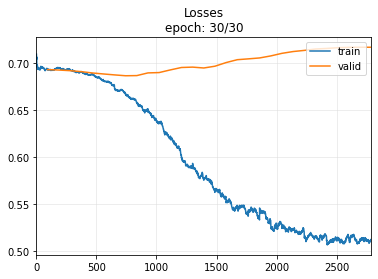

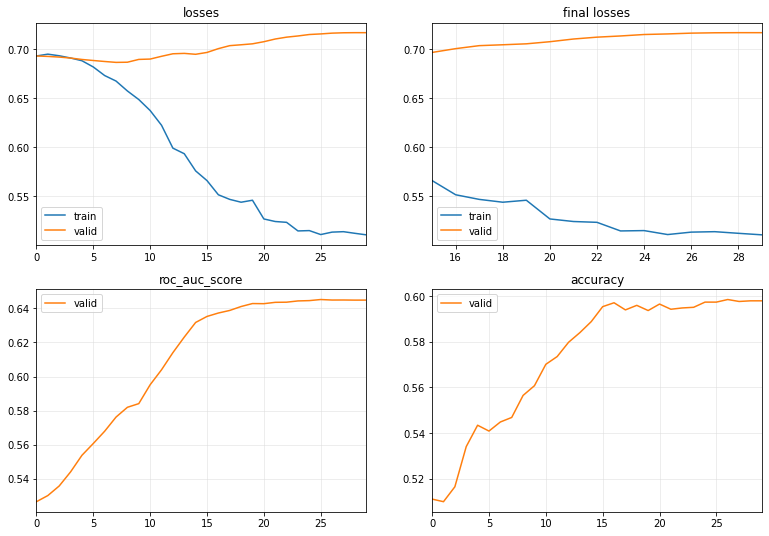

In [ ]:
evaluate_model(model)

## Our TST

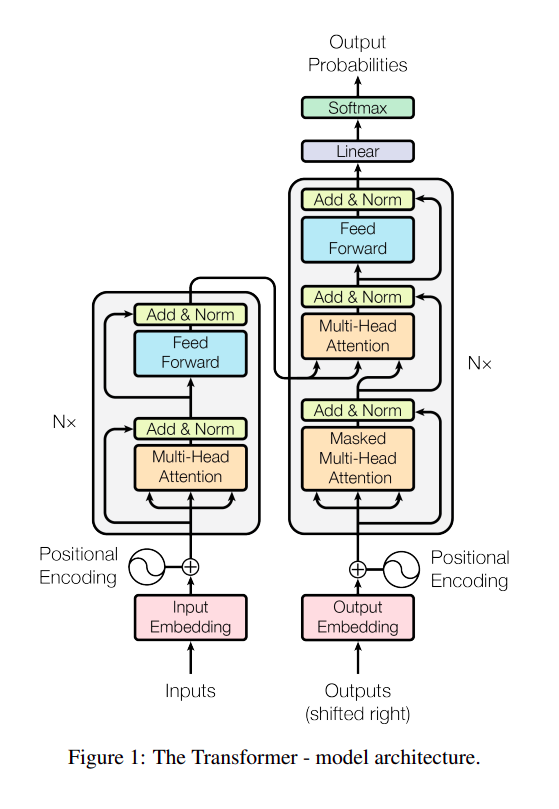

The diagram above illustrates the Transformer architecture as presented in the "Attention is All You Need" paper. The breakthrough in this architecture is the [Multi-Head Attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). The idea behind Attention is that if your model can focus on the most important parts of a long sequence, it can perform better without being affected by noise.

How does it work? Well, in my experience, when we are not very familiar with a new architecture, we shouldn't focus too much on understanding every detail of the architecture. I spent a lot of time reading various tutorials, trying to grasp the clever idea behind this, only to realize that I still didn't know how to apply it to a real case. I will attempt to cover building Self-Attention from scratch in a future blog post. However, in this one, we will start by learning how to use the Self-Attention module from PyTorch.

What do we need to pay attention to here? Mainly the shapes of the input and output. For our specific application, we will use Self-Attention, which treats all three parameters (query, key, and value) as the same tensor, and preserves the shape of the output.

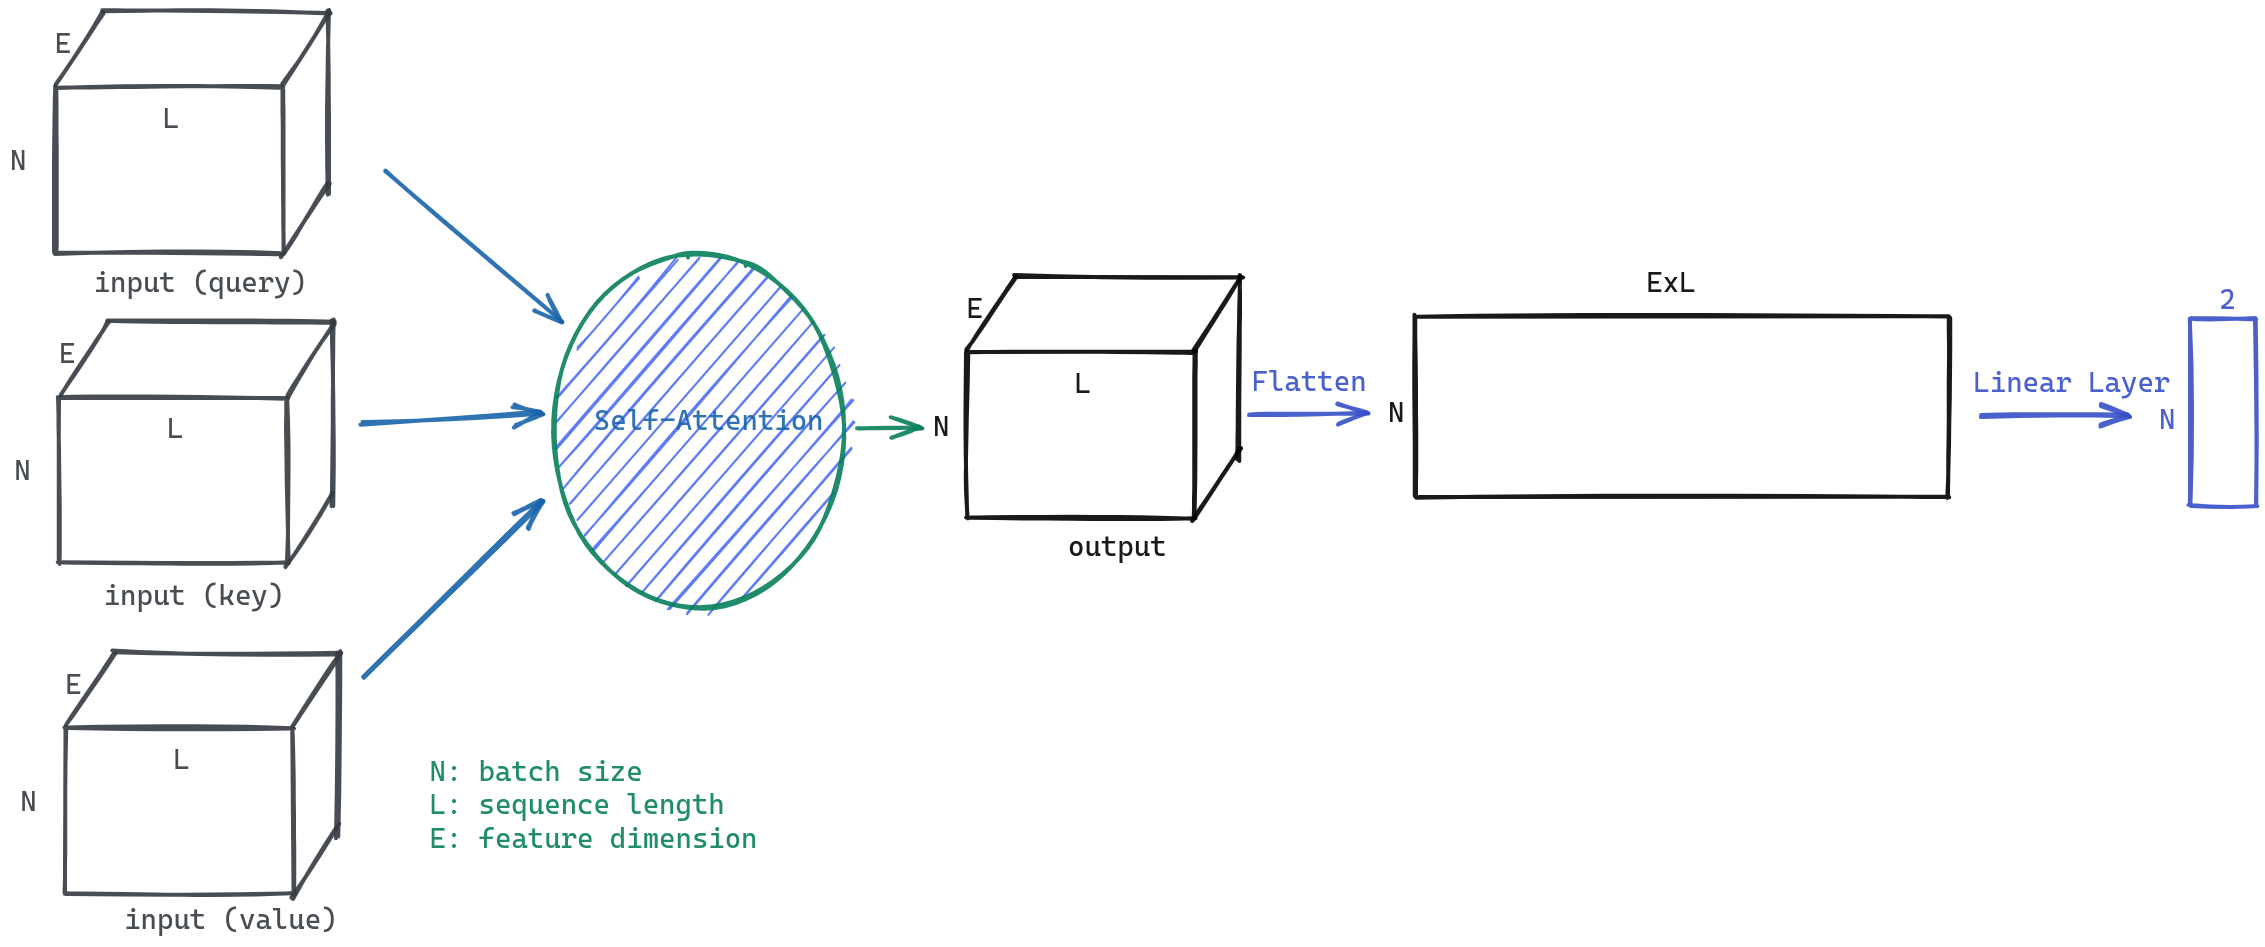

We will begin by constructing the simplest Transformer model, which consists of a `Self-Attention` layer stacked with a Linear Layer that adapts to the number of classification outputs.

In [ ]:
class OurTST(Module):
    def __init__(self, c_in, c_out, seq_len):
        self.c_in, self.c_out, self.seq_len = c_in, c_out, seq_len
        self.encoder = nn.MultiheadAttention(embed_dim=c_in, num_heads=1, batch_first=True)
        self.head = nn.Linear(seq_len*c_in, c_out)
    def forward(self, x):
        o = x.swapaxes(1,2)
        o = self.encoder(o,o,o)[0]
        o = o.reshape(o.shape[0], -1)
        o = self.head(o)
        return o

In [ ]:
model = OurTST(c_in, c_out, seq_len)

In [ ]:
model

OurTST(
  (encoder): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
  )
  (head): Linear(in_features=8928, out_features=2, bias=True)
)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.695951,0.692411,0.525592,0.511635,00:01
1,0.692179,0.691621,0.543148,0.527242,00:01
2,0.689011,0.690405,0.564887,0.538593,00:01
3,0.683291,0.689369,0.580379,0.559308,00:01
4,0.667550,0.685884,0.605005,0.576334,00:01
5,0.645704,0.693245,0.613381,0.590238,00:01
6,0.627285,0.691571,0.643158,0.608400,00:01
7,0.600961,0.693096,0.658148,0.619467,00:01
8,0.583125,0.697477,0.668006,0.624291,00:01
9,0.572355,0.708262,0.670622,0.627696,00:01


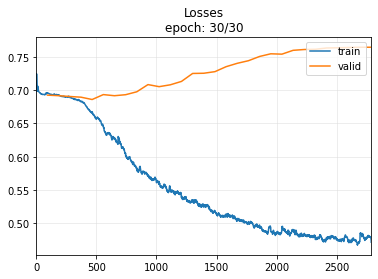

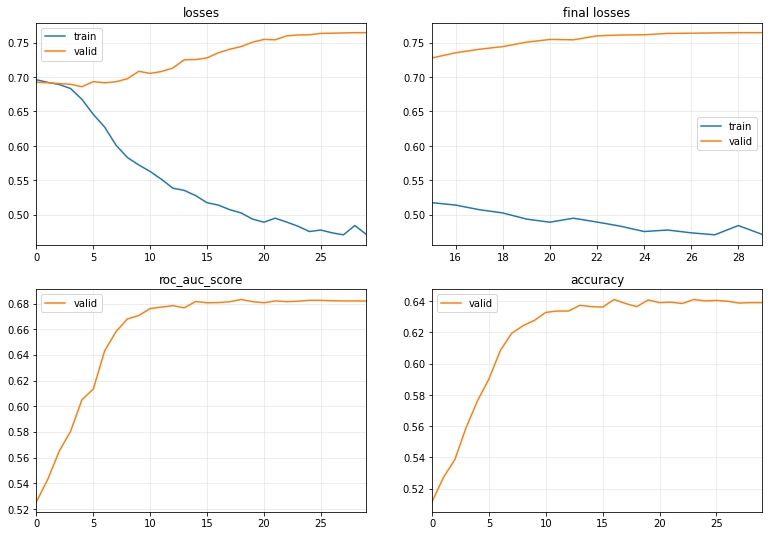

In [ ]:
evaluate_model(model)

Well, our model outperforms the LSTM model and not far behind the TST model

(To be continued): I will update the model until it reaches the performance of the TST Model, so stay tuned!